# Bikes per hour rent

The following notebook reviews the bike sharing dataset to extract the total number of bikes per hour according to the different months, weather, working days or holidays.


In [28]:
#import utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib as mpl
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import scipy
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.figsize'] = [4.5, 3.5]

%matplotlib inline
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore')

## Data Analysis


In [29]:
# https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

hour_df = pd.read_csv("../datasets/bike_sharing_dataset/hour.csv", delimiter=",")
# print first 10 examples
hour_df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


### Density of total bikes per hour

The following histogram plot, shows the pure data of the Count per hour of the raw data. the data is skew to the right with a big skewness.


Text(0, 0.5, 'Density')

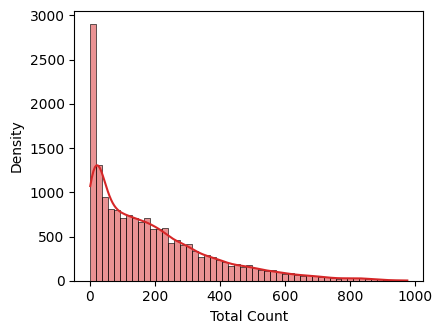

In [30]:
sns.histplot(hour_df["cnt"], kde=True, color="tab:red")
plt.xlabel("Total Count")
plt.ylabel("Density")

#### Overcome Skewness

To overcome the skewness of the data, we can use data transformers based on the logarithmic calculations to convert the data to a normal distribution.


In [31]:
logTr = ColumnTransformer(transformers=[("lg", FunctionTransformer(np.log1p), ["cnt"])])
df_log = pd.DataFrame(logTr.fit_transform(hour_df))

Text(0, 0.5, 'Density')

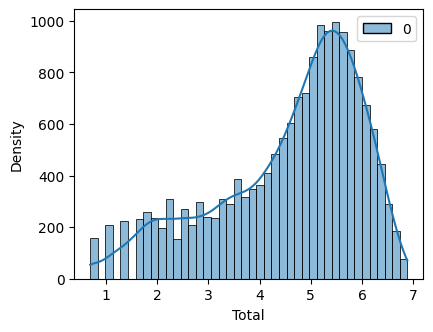

In [32]:
sns.histplot(df_log, kde=True)
plt.xlabel("Total")
plt.ylabel("Density")

## Distribution according to the weather, seasons, working day and month

There is an obvious correlation between total counts of rent bikes and **weather**, where the participation increases, the amount of rent bikes decreases. it make sense for the people to prefer other types of transportation when the weather has participation or very hot. This can also inspired by the **Season** and **Month**, in the time of the year which the weather is mild, the number of rent bikes increases.

The amount of bike rental is also a function of **working days**, in the weekends or vacations, the number of rent biked decreases which means people which use it for commuting are not using it in the vacations. but the correlation between these features are much less than the weather condition.

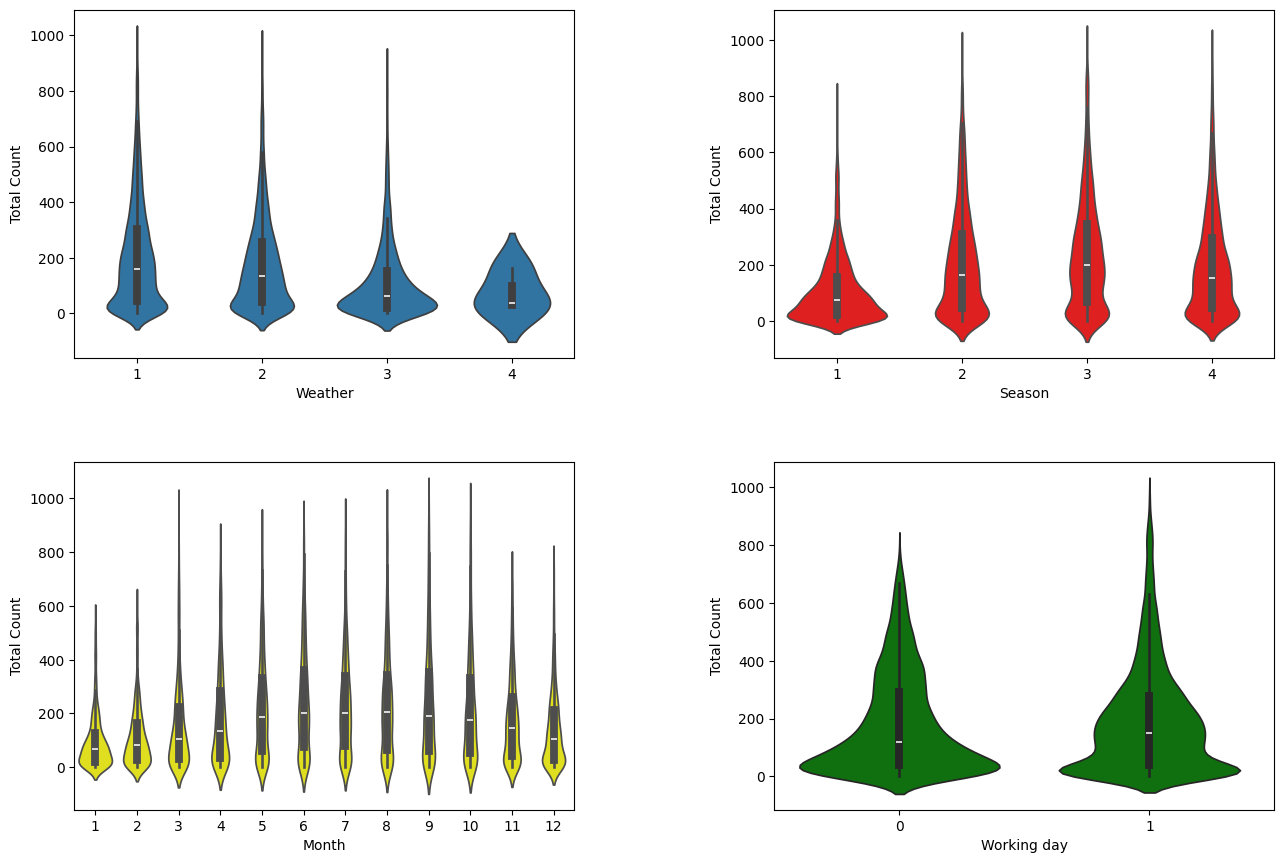

In [33]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15, 10)

sns.violinplot(data=hour_df, y="cnt", x="weathersit", ax=axs[0,0])
axs[0,0].set_xlabel("Weather")
axs[0,0].set_ylabel("Total Count")

sns.violinplot(data=hour_df, y="cnt", x="season", ax=axs[0,1], color="red")
axs[0,1].set_xlabel("Season")
axs[0,1].set_ylabel("Total Count")

sns.violinplot(data=hour_df, y="cnt", x="mnth", ax=axs[1,0], color="yellow")
axs[1,0].set_xlabel("Month")
axs[1,0].set_ylabel("Total Count")

sns.violinplot(data=hour_df, y="cnt", x="workingday", ax=axs[1,1], color="green")
axs[1,1].set_xlabel("Working day")
axs[1,1].set_ylabel("Total Count")

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)

plt.show()

## Bike rent per weekday and hour

In the working days, rent bike count is higher thant he weekends, and specifically, in the commuting time range it increases meaningfully.
A minor correlation is visible between the bike rend count and the day of the week. this means that event there is a correlation between working days and non-working days, it is a very small correlation.

In fact, users, choose a different time of the day to rent a bike during the working days.

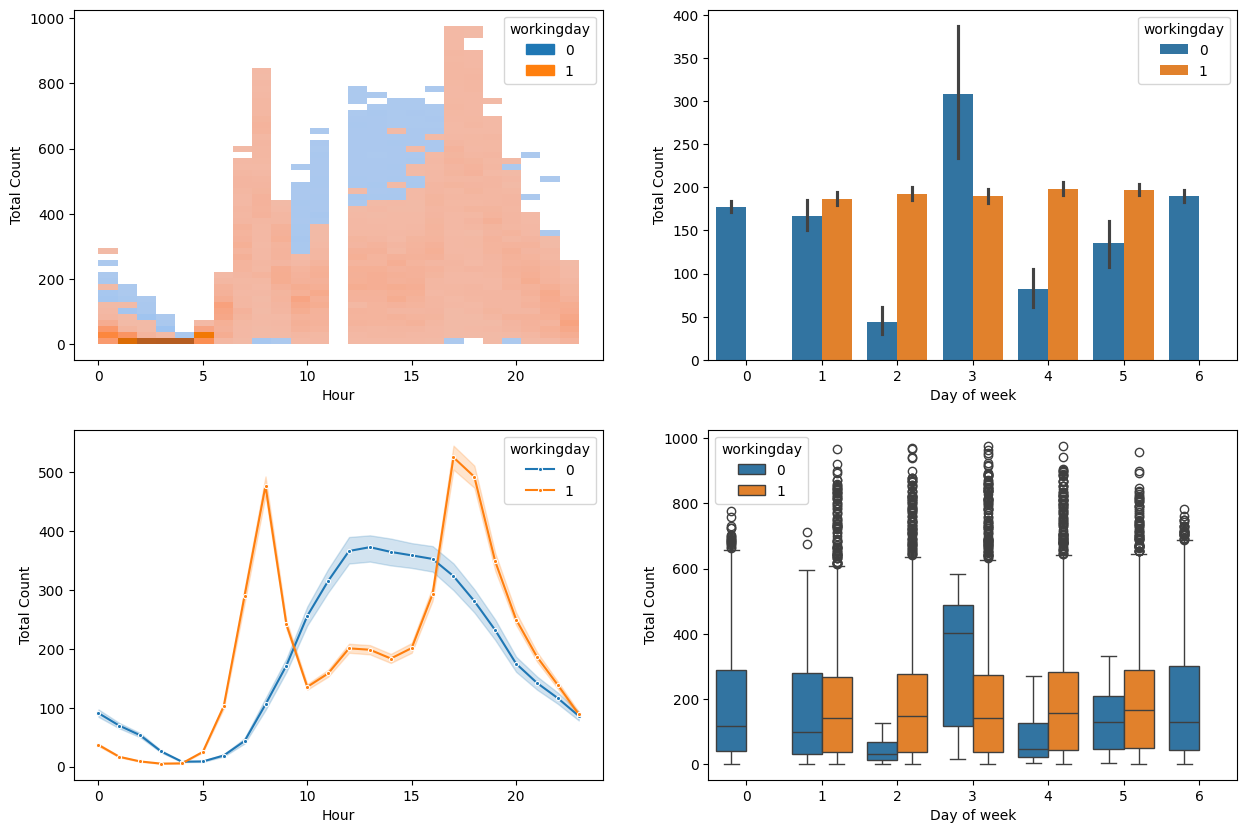

In [34]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15, 10)
sns.histplot(data=hour_df, x="hr", y="cnt", hue="workingday", ax=axs[0, 0])
axs[0, 0].set_xlabel("Hour")
axs[0, 0].set_ylabel("Total Count")
sns.barplot(data=hour_df, x="weekday", y="cnt", hue="workingday", ax=axs[0, 1])
axs[0, 1].set_xlabel("Day of week")
axs[0, 1].set_ylabel("Total Count")
sns.lineplot(data=hour_df, x="hr", y="cnt", hue="workingday", marker=".", markers=True, dashes=False, ax=axs[1, 0])
axs[1, 0].set_xlabel("Hour")
axs[1, 0].set_ylabel("Total Count")
sns.boxplot(data=hour_df, x="weekday", y="cnt", hue="workingday", ax=axs[1, 1])
axs[1, 1].set_xlabel("Day of week")
axs[1, 1].set_ylabel("Total Count")


plt.show()

## Bike Rent to season

There is a positive correlation between the season and the number of bikes rent. in the following plot, we can obviously see that the second year has more bikes rent ber hour, this means the overall increment in the popularity of bike renting program.

Text(0, 0.5, 'Total Count')

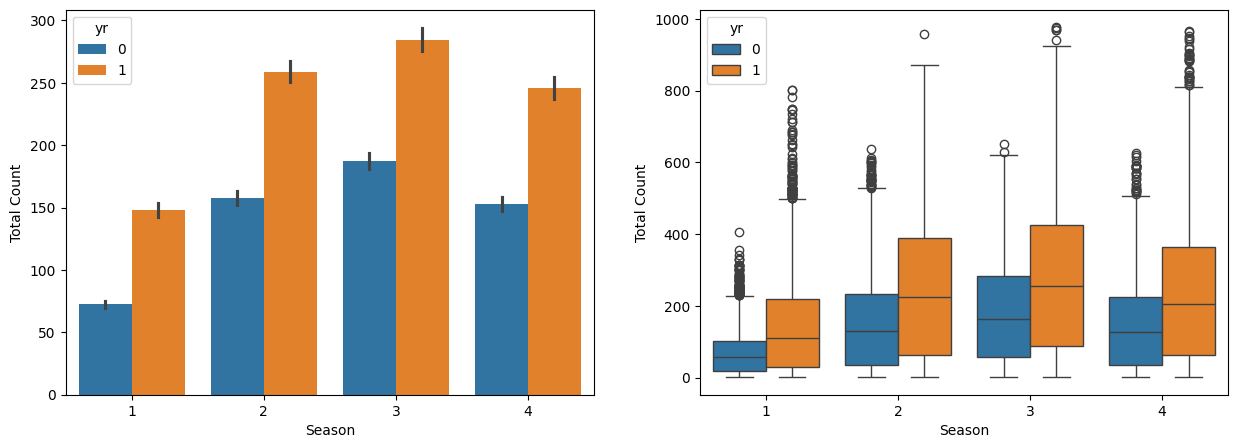

In [35]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
sns.barplot(x="season", y="cnt", data=hour_df, hue="yr", ax=axs[0])
axs[0].set_xlabel("Season")
axs[0].set_ylabel("Total Count")
sns.boxplot(x="season", y="cnt", data=hour_df, hue="yr", ax=axs[1])
axs[1].set_xlabel("Season")
axs[1].set_ylabel("Total Count")

## Bike Rent to the temperature

There is a positive correlation between temperature and bikes rent, people prefer to use bikes in a warm-mild weather instead of Hot or cold.

Text(0, 0.5, 'Total Count')

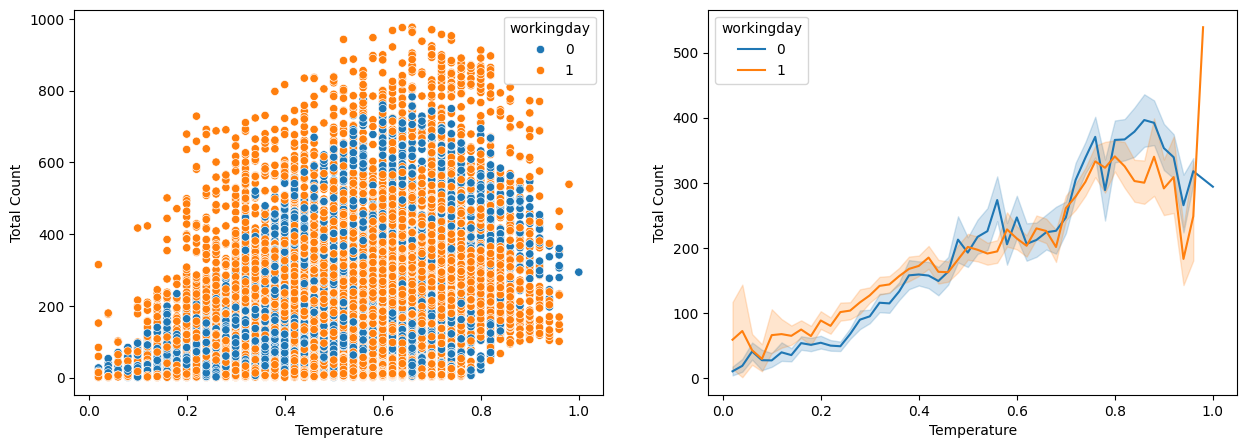

In [36]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
sns.scatterplot(x="temp", y="cnt", data=hour_df, hue="workingday", ax=axs[0])
axs[0].set_xlabel("Temperature")
axs[0].set_ylabel("Total Count")
sns.lineplot(x="temp", y="cnt", data=hour_df, hue="workingday", ax=axs[1])
axs[1].set_xlabel("Temperature")
axs[1].set_ylabel("Total Count")

## Bike Rent to the humidity

There is a negative correlation between number of rent bikes and humidity, as it increase, the number of rent bikes decreases.

Text(0, 0.5, 'Total Count')

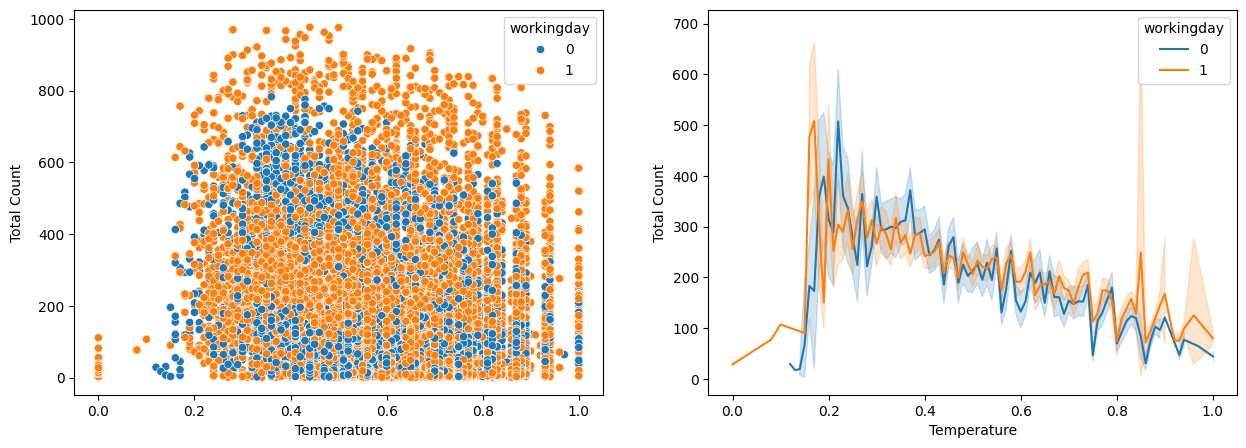

In [37]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
sns.scatterplot(x="hum", y="cnt", data=hour_df, hue="workingday", ax=axs[0])
axs[0].set_xlabel("Temperature")
axs[0].set_ylabel("Total Count")
sns.lineplot(x="hum", y="cnt", data=hour_df, hue="workingday", ax=axs[1])
axs[1].set_xlabel("Temperature")
axs[1].set_ylabel("Total Count")

## Bike Rent to wind speed

There is a negative relation between rent bikes and wind speed, it also has different behavior in different seasons, where the wind speed between 0.4 and 0.6 has a different bike usage rate in th different seasons, in the warmer seasons, the usage is much more than cold seasons.

Text(0, 0.5, 'Total Count')

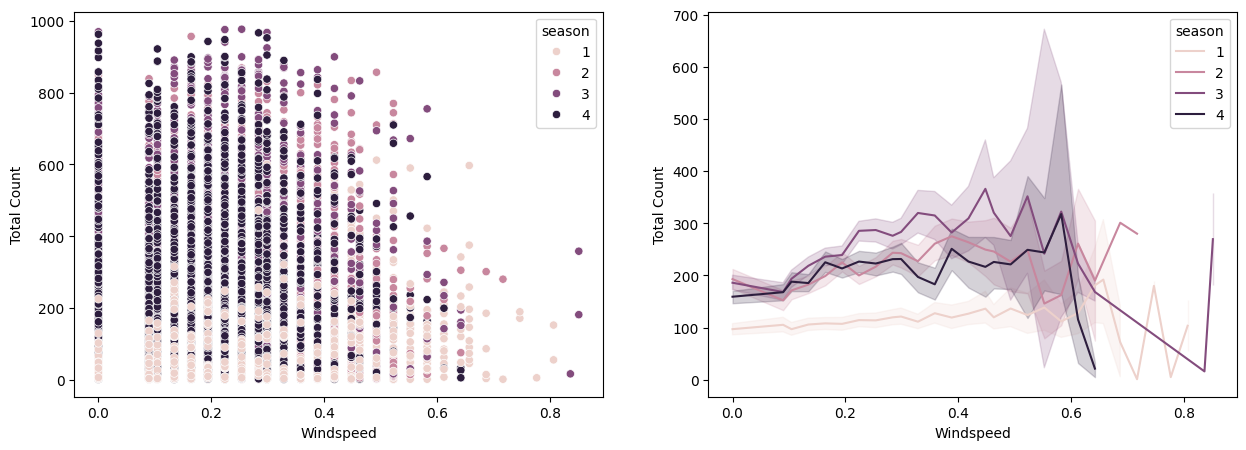

In [38]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
sns.scatterplot(x="windspeed", y="cnt", data=hour_df, hue="season", ax=axs[0])
axs[0].set_xlabel("Windspeed")
axs[0].set_ylabel("Total Count")
sns.lineplot(x="windspeed", y="cnt", data=hour_df, hue="season", ax=axs[1])
axs[1].set_xlabel("Windspeed")
axs[1].set_ylabel("Total Count")

## Predictions


The following function predicts the X according to y and calculates MAE, RMSE, and MAPE for the prediction task.

In [39]:
def predict_error(model, X_tr, X_ts, y_tr, y_ts):
    model = model.fit(X_tr, y_tr)
    test_predictions = model.predict(X_ts)
    mae = mean_absolute_error(y_ts, test_predictions)
    rmse = root_mean_squared_error(y_ts, test_predictions)
    mape = mean_absolute_percentage_error(y_ts, test_predictions)
    return mae, rmse, mape

In [40]:
# # models used for the prediction
models = {
    "Knn": KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": XGBRegressor(),
}

# # the errors dict which contains the final results
all_errors = {
    "mae": {},
    "rmse": {},
    "mape": {},
}

# # initialize the errors and corresponding models
for name, _ in models.items():
    all_errors["mae"][name] = {}
    all_errors["rmse"][name] = {}
    all_errors["mape"][name] = {}

The following function, calculates the error of all the models for the specific feature pair and populates the data to the `all_errors`

In [41]:
def calc_errors(feature_pair, X, y):
    n_folds = 10
    for name, model in models.items():
        model_errors = {
            "mae": [],
            "rmse": [],
            "mape": [],
        }
        kf = KFold(n_splits=n_folds)
        i = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            t_mae, t_rmse, t_mape = predict_error(
                model, X_train, X_test, y_train, y_test
            )
            model_errors["mae"].append(t_mae)
            model_errors["rmse"].append(t_rmse)
            model_errors["mape"].append(t_mape)
            i += 1

        mae = np.mean(model_errors["mae"])
        rmse = np.mean(model_errors["rmse"])
        mape = np.mean(model_errors["mape"])
        all_errors["mae"][name][feature_pair] = mae
        all_errors["rmse"][name][feature_pair] = rmse
        all_errors["mape"][name][feature_pair] = mape

        print(name + " MAE:", mae)
        print(name + " RMSE:", rmse)
        print(name + " MAPE:", mape)
        print("----------------------------------")

## Predict with Month and Hour

Adding the prediction errors for month-hour combination of the features to predict the count of rent bike.

In [42]:
calc_errors("month_hour",hour_df.loc[:, ["mnth", "hr"]], hour_df.loc[:, "cnt"])

Knn MAE: 100.46524821905685
Knn RMSE: 145.58266716085774
Knn MAPE: 1.1944162101232603
----------------------------------
DecisionTree MAE: 97.96768116779967
DecisionTree RMSE: 139.564262346442
DecisionTree MAPE: 1.2401721620565644
----------------------------------
RandomForest MAE: 97.9977223592303
RandomForest RMSE: 139.6157639825604
RandomForest MAPE: 1.2402948319260474
----------------------------------
GradientBoosting MAE: 97.9666281751893
GradientBoosting RMSE: 139.56300287991155
GradientBoosting MAPE: 1.2401115546126662
----------------------------------


## Predict with Working day and Hour

Adding the prediction errors for workingday-hour combination of the features to predict the count of rent bike.

In [43]:
calc_errors("workingday_hour", hour_df.loc[:, ["workingday", "hr"]], hour_df.loc[:, "cnt"])

Knn MAE: 138.35088123313545
Knn RMSE: 185.42996172254226
Knn MAPE: 0.7545670663512674
----------------------------------
DecisionTree MAE: 77.94601310512344
DecisionTree RMSE: 110.6288237198831
DecisionTree MAPE: 0.8857190452813718
----------------------------------
RandomForest MAE: 77.95445706096805
RandomForest RMSE: 110.63215482626701
RandomForest MAPE: 0.8857968457558772
----------------------------------
GradientBoosting MAE: 77.94601348757809
GradientBoosting RMSE: 110.62882668912889
GradientBoosting MAPE: 0.8857196619774458
----------------------------------


## Predict with Season day and Hour

Adding the prediction errors for season-hour combination of the features to predict the count of rent bike.

In [44]:
calc_errors("season_hour", hour_df.loc[:, ["season", "hr"]], hour_df.loc[:, "cnt"])

Knn MAE: 93.68433019113547
Knn RMSE: 134.0603187290905
Knn MAPE: 1.0010776277433788
----------------------------------
DecisionTree MAE: 89.45754788479584
DecisionTree RMSE: 128.88063781488603
DecisionTree MAPE: 1.2055781215227839
----------------------------------
RandomForest MAE: 89.43656916983217
RandomForest RMSE: 128.86338464922068
RandomForest MAPE: 1.2054284428519315
----------------------------------
GradientBoosting MAE: 89.4575384910656
GradientBoosting RMSE: 128.880635864366
GradientBoosting MAPE: 1.2055774968455426
----------------------------------


## Predict with Temperature day and Hour

Adding the prediction errors for temperature-hour combination of the features to predict the count of rent bike.

In [45]:
calc_errors("temp_hour", hour_df.loc[:, ["temp", "hr"]], hour_df.loc[:, "cnt"])

Knn MAE: 85.83448449206435
Knn RMSE: 125.01746846645335
Knn MAPE: 0.8828524626638424
----------------------------------
DecisionTree MAE: 81.34278740019987
DecisionTree RMSE: 117.50303447025506
DecisionTree MAPE: 1.0941056075764173
----------------------------------
RandomForest MAE: 81.29503603721213
RandomForest RMSE: 117.35801452506954
RandomForest MAPE: 1.0920551448112
----------------------------------
GradientBoosting MAE: 80.86669532059578
GradientBoosting RMSE: 116.70754990611461
GradientBoosting MAPE: 1.0930096479261089
----------------------------------


## Analyze the feature selection

### Knn

The following plots, show the calculated errors of MAE, RMSE, and MAPE with Knn model. X axis shows the feature set which were chosen in previous steps.

Text(0, 0.5, 'MAPE')

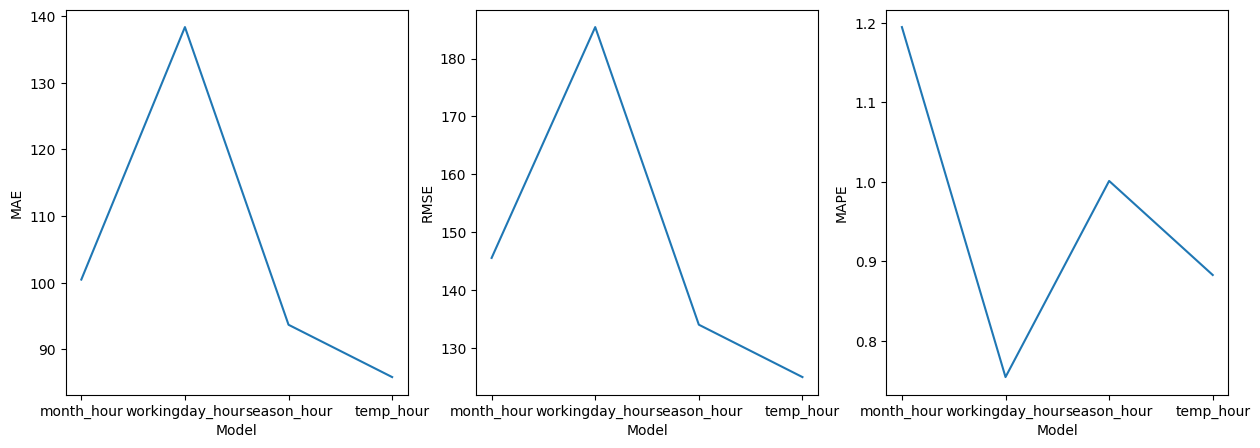

In [46]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
sns.lineplot(all_errors["mae"]["Knn"], ax=axs[0])
axs[0].set_xlabel("Model")
axs[0].set_ylabel("MAE")
sns.lineplot(all_errors["rmse"]["Knn"], ax=axs[1])
axs[1].set_xlabel("Model")
axs[1].set_ylabel("RMSE")
sns.lineplot(all_errors["mape"]["Knn"], ax=axs[2])
axs[2].set_xlabel("Model")
axs[2].set_ylabel("MAPE")

### Decision Tree

The following plots, show the calculated errors of MAE, RMSE, and MAPE with Knn model. X axis shows the feature set which were chosen in previous steps.

Text(0, 0.5, 'MAPE')

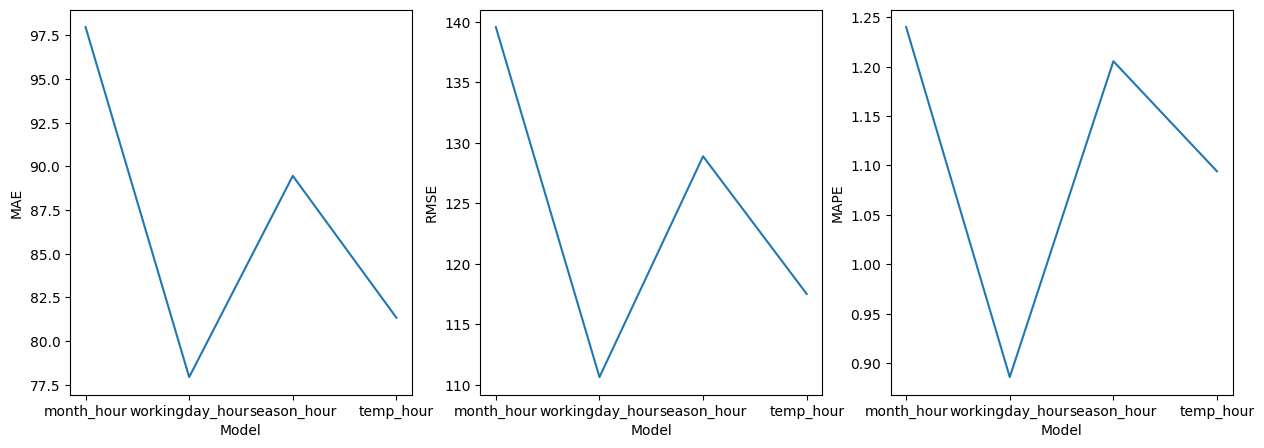

In [47]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
sns.lineplot(all_errors["mae"]["DecisionTree"], ax=axs[0])
axs[0].set_xlabel("Model")
axs[0].set_ylabel("MAE")
sns.lineplot(all_errors["rmse"]["DecisionTree"], ax=axs[1])
axs[1].set_xlabel("Model")
axs[1].set_ylabel("RMSE")
sns.lineplot(all_errors["mape"]["DecisionTree"], ax=axs[2])
axs[2].set_xlabel("Model")
axs[2].set_ylabel("MAPE")

### Random Forest

The following plots, show the calculated errors of MAE, RMSE, and MAPE with Knn model. X axis shows the feature set which were chosen in previous steps.

Text(0, 0.5, 'MAPE')

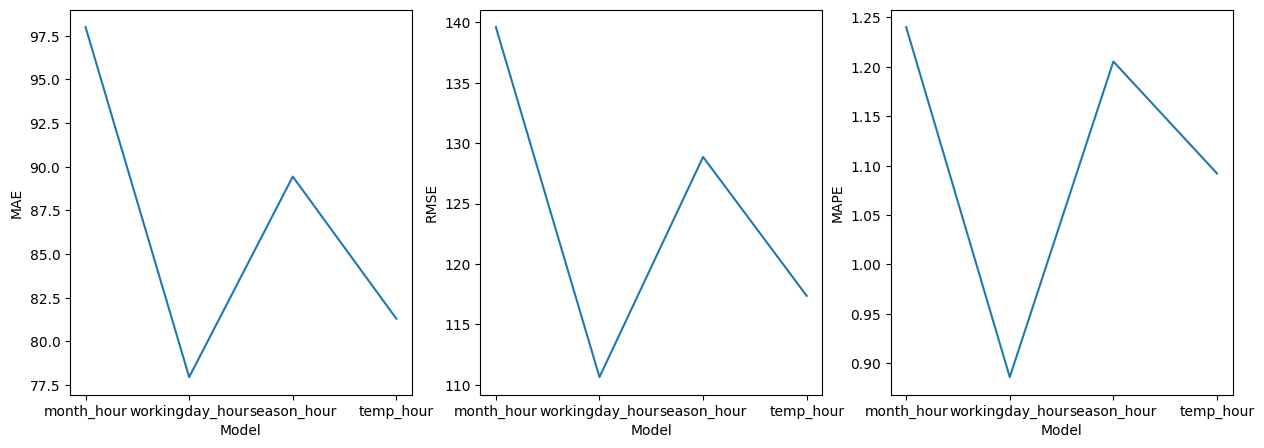

In [48]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
sns.lineplot(all_errors["mae"]["RandomForest"], ax=axs[0])
axs[0].set_xlabel("Model")
axs[0].set_ylabel("MAE")
sns.lineplot(all_errors["rmse"]["RandomForest"], ax=axs[1])
axs[1].set_xlabel("Model")
axs[1].set_ylabel("RMSE")
sns.lineplot(all_errors["mape"]["RandomForest"], ax=axs[2])
axs[2].set_xlabel("Model")
axs[2].set_ylabel("MAPE")

### Gradient Boosting

The following plots, show the calculated errors of MAE, RMSE, and MAPE with Knn model. X axis shows the feature set which were chosen in previous steps.

Text(0, 0.5, 'MAPE')

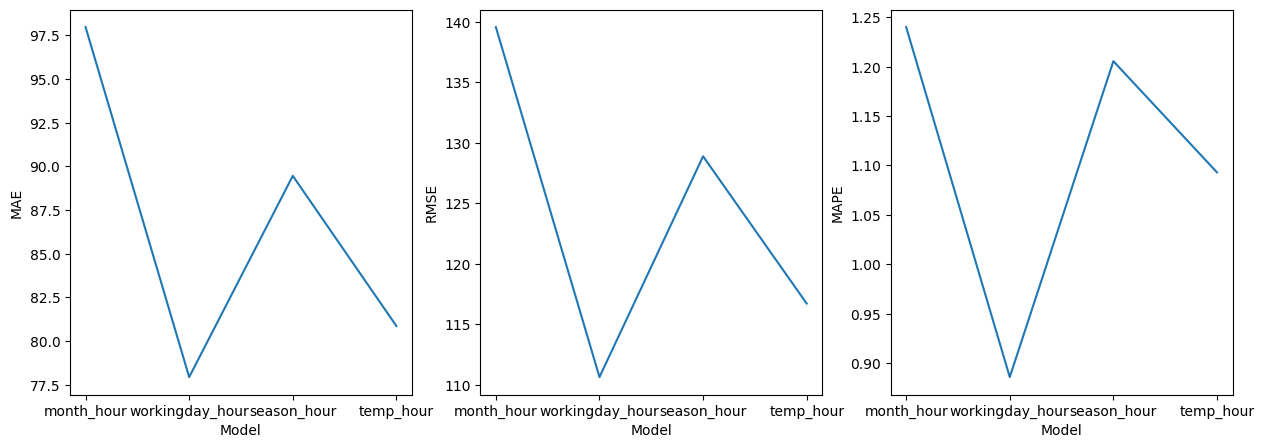

In [49]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
sns.lineplot(all_errors["mae"]["GradientBoosting"], ax=axs[0])
axs[0].set_xlabel("Model")
axs[0].set_ylabel("MAE")
sns.lineplot(all_errors["rmse"]["GradientBoosting"], ax=axs[1])
axs[1].set_xlabel("Model")
axs[1].set_ylabel("RMSE")
sns.lineplot(all_errors["mape"]["GradientBoosting"], ax=axs[2])
axs[2].set_xlabel("Model")
axs[2].set_ylabel("MAPE")

# Conclusion

Using different models for the predictions, the lowest error is for the **working day** and hour. deduct would that the best option for the feature pick. but ***it is not correct***, in the data analysis section, we understood that there is not a large correlation between the working day and number of rent bikes, so it is a kind of over-fitting with a value that has no relation with count of the rent bikes.

The better one would be **Temperature**, in the data analysis phase, it was clearly stated that there is a outstanding correlation between the weather, temperature and season between rental count.